This notebook is used to identify optimal test measurement strategies for an ecommerce retail dataset. Its primary objectives are to determine the best way to measure customer based tests.  It also includes functionality to identify, and cap or remove sales outliers.

It includes functions to import data, visualize the data, measure tests, conduct nulltest simulations, and remove/cap outliers. Throughout, I'll provide markdown comments to discuss code that may need explanation, and interpretation of the results.

If you are charged with making customer A/B test measurements, this functionality can greatly help you identify optimal ways to make measurements with the least possible noise.

Here is the measurement optimization analysis writeup: https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository

To run this notebook in your own environment, I recommend the following steps:

Install the pathlib, pandas, numpy, datetime, scipy, matplotlib, and random modules. These modules are used by the functionality in Get the dataset at Kaggle: https://www.kaggle.com/datasets/manjeetsingh/retaildataset Download this notebook Update the file import path in step #2 below: It currently points to the filepath on my machine

Import the Python Libraries used in the analysis

In [2]:
from pathlib import Path

import pandas as pd
from pandas import read_csv
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

from datetime import datetime
from datetime import  timedelta

from dateutil import parser #date parsing function

#random generator used in nulltests
import random

#correlation used in nulltest results, and similar sites creation
import scipy.stats
from scipy import stats
from scipy.stats import pearsonr


def parse_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except ValueError:
        # Handle cases where parsing fails
        return pd.NaT


Importing the dataset.  The data is sourced from Kaggle.

https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository

In [53]:
#import the dataset.  It is in two parts.  
dataset_retail = read_csv("/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/online_retail_II_09_10.csv")
dataset_retail_2 = read_csv("/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/online_retail_I_10_11.csv")

#bring the two dataframes together
dataset_retail = pd.concat([dataset_retail, dataset_retail_2], ignore_index=True)

#change dates to date format
dataset_retail['InvoiceDate'] = pd.to_datetime(dataset_retail['InvoiceDate'], format='mixed')




First, look at the dataset values and columns.   We need to create a sales metric per row.  it is price * quantity.  There are multiple rows per invoice.  These can be grouped, sales summed to aggregate data to the transaction level.  Customer id, and date are important for customer time series sales, and test measurement.

In [54]:
dataset_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Data starts as SKU level purchase data, with multiple rows per transaction.  Group and sum by transaction ID for sales/ trx.  Do the same for date and customer id and merge.

In [55]:
#there is a quantity and price column, but not a sales line.  Create the sales metric by multiplying price and quantity
dataset_retail['SKU_sales'] = dataset_retail['Quantity'] * dataset_retail['Price']

#each SKU in a transaction is a multiple row.  I want to combine SKU sales to total sales for the transaction.  
#I need the sales, date, and customer id columns

trx_summed = dataset_retail.groupby('Invoice')['SKU_sales'].sum().reset_index()
trx_date = dataset_retail.groupby('Invoice')['InvoiceDate'].min().reset_index()
trx_cust = dataset_retail.groupby('Invoice')['Customer ID'].min().reset_index()

#merge the columns into a single dataframe
trx_summed = trx_summed.merge(trx_date, on='Invoice')
trx_summed = trx_summed.merge(trx_cust, on='Invoice')

#cast sales as a float type
trx_summed['SKU_sales'] = trx_summed['SKU_sales'].astype(float)

#pull descriptive stats
stdev_index = trx_summed['SKU_sales'].std()
mean = trx_summed['SKU_sales'].mean()



Understanding the distribution of transaction size via histogram.  Also flagging outliers that are +- 3 standard devs from the mean.  
Note that outliers extend out to $150K transaction size, where the lowest outlier level (mean + 3 standard deviations) is $5.3K.  
There are also many negative transactions

stdev of data 1654.8292884069403


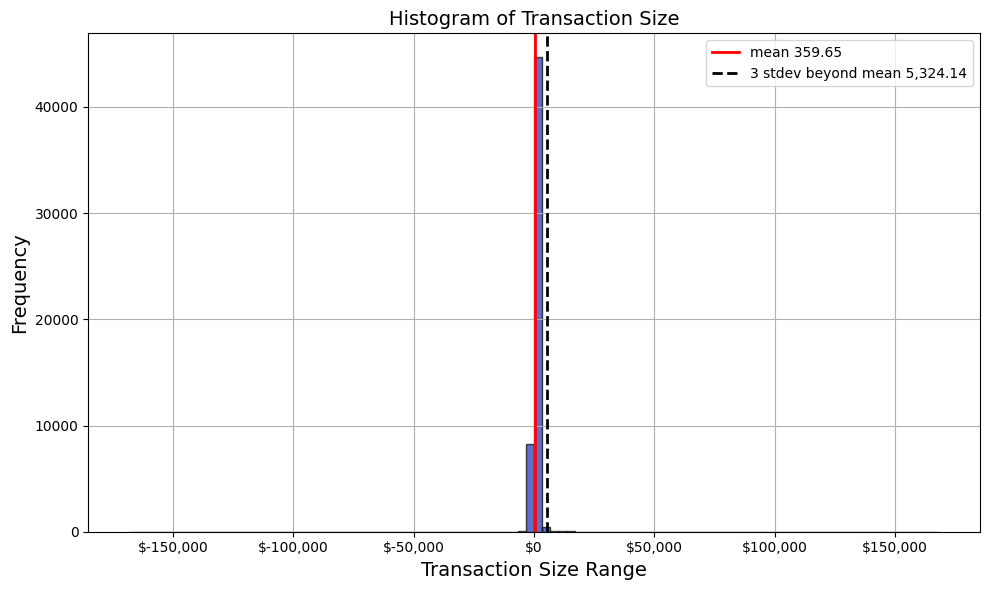

In [5]:
#understanding the distribution of transaction size via histogram.  Also flagging outliers that are +- 3 standard devs from the mean

stdev_index = trx_summed['SKU_sales'].std()
print(f"stdev of data {stdev_index}")
mean = trx_summed['SKU_sales'].mean()

# Plotting the histogram of trx size
plt.figure(figsize=(10, 6))
plt.hist(trx_summed['SKU_sales'], bins=100, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
plt.axvline(stdev_index*3+mean, color='black', linestyle = '--',linewidth=2, label=f'3 stdev beyond mean {stdev_index*3+mean:,.2f}')
plt.title("Histogram of Transaction Size", fontsize=14)
plt.xlabel("Transaction Size Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Capping transaction size to reduce the influence of outliers.  Outlier transactions are brought down to the mean + 3 standard deviations.

In [8]:
#stdev and mean of the dataset
stdev_index = trx_summed['SKU_sales'].std()
mean = trx_summed['SKU_sales'].mean()

#printing mean and standard deviation
print(f"stdev: ${stdev_index:,.0f}, mean: ${mean:,.0f}")

#trx count, sum of sales, max trx size before outlier capping
print(f"count of trx pre cap: {trx_summed['SKU_sales'].count()}")
print(f"sum of sales pre cap: ${trx_summed['SKU_sales'].sum():,.0f}")
print(f"max trans size pre cap: ${trx_summed['SKU_sales'].max():,.0f}")

#outlier capping.  mean +- 3 standard deviations
outlier_capped_trx_data = trx_summed.copy()
outlier_capped_trx_data.loc[outlier_capped_trx_data['SKU_sales'] > mean + stdev_index*3, 'SKU_sales'] = mean + stdev_index*3
outlier_capped_trx_data.loc[outlier_capped_trx_data['SKU_sales'] < mean - stdev_index*3, 'SKU_sales'] = mean - stdev_index*3

#standard deviation and mean after capping
print(f"\nstdev: ${stdev_index_cap:,.0f}, mean: ${mean_cap:,.0f}")

#trx count, sum of sales, max trx size after outlier capping
print(f"count of trx post cap: {outlier_capped_trx_data['SKU_sales'].count()}")
print(f"sum of sales post cap: ${outlier_capped_trx_data['SKU_sales'].sum():,.0f}")
print(f"max trans size post cap: ${outlier_capped_trx_data['SKU_sales'].max():,.0f}")

#standard dev and mean after capping
stdev_index_cap = outlier_capped_trx_data['SKU_sales'].std()
mean_cap = outlier_capped_trx_data['SKU_sales'].mean()



#what # of sales came from the sales we removed from capped outliers?
print(f"percent of sales removed from capped outliers: {(trx_summed['SKU_sales'].sum() - outlier_capped_trx_data['SKU_sales'].sum()) / trx_summed['SKU_sales'].sum() * 100:,.1f}%")

stdev: $1,655, mean: $360
count of trx pre cap: 53628
sum of sales pre cap: $19,287,251
max trans size pre cap: $168,470

stdev: $682, mean: $340
count of trx post cap: 53628
sum of sales post cap: $18,231,386
max trans size post cap: $5,324
percent of sales removed from capped outliers: 5.5%


Histogram of tranaction size after outlier capping.  Note the spike at $5.3K where outliers were capped.

stdev of data $682


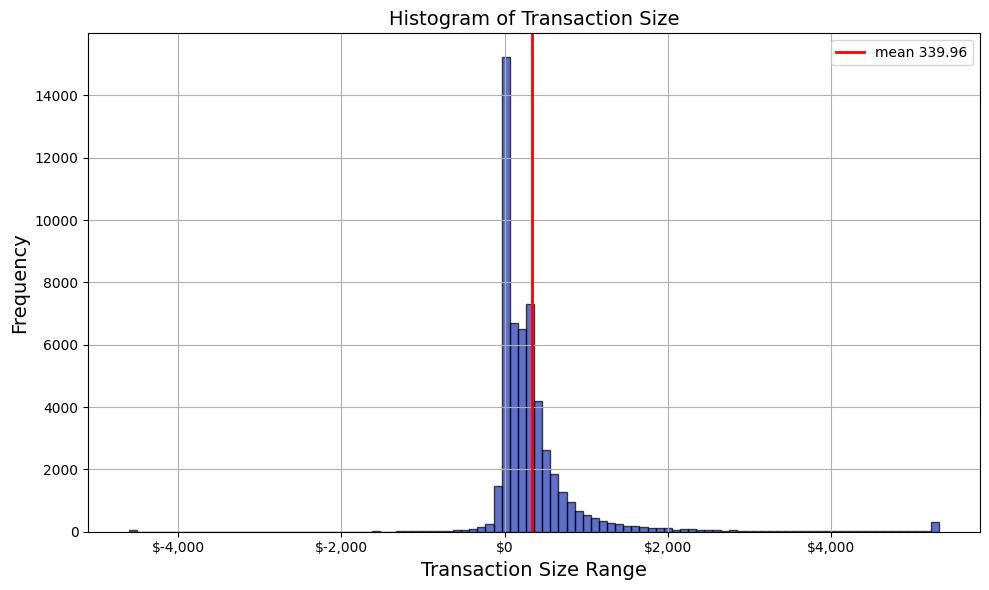

In [11]:
stdev_index = outlier_capped_trx_data['SKU_sales'].std()
print(f"stdev of data ${stdev_index:,.0f}")
mean = outlier_capped_trx_data['SKU_sales'].mean()

# Plotting the histogram of trx size
plt.figure(figsize=(10, 6))
plt.hist(outlier_capped_trx_data['SKU_sales'], bins=100, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
plt.title("Histogram of Transaction Size", fontsize=14)
plt.xlabel("Transaction Size Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Histogram of transactions per customer.  Looking for customers with outlying frequency of shop.  Outlying sales with more than 3 standard devs beyond the mean are 55+ transactions.

Currently, I'm removing the outlying customers to make the analysis simpler.  In a production environment, we would either need to either structure tests
such that these customers are identically represented in test and control, or we can design tests that don't include these customers which mimics the removal I'm doing here.

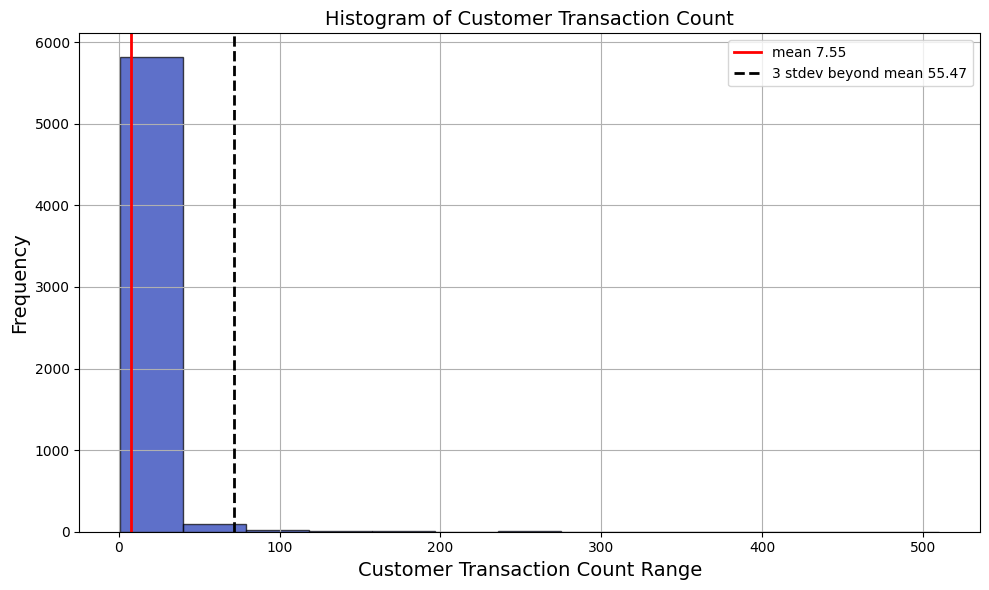

In [13]:
#cust trx counts
customer_sales = outlier_capped_trx_data.groupby('Customer ID')['Invoice'].count().reset_index()
customer_sales.columns = ['Customer ID', 'Invoice_Count']
stdev_index = customer_sales['Invoice_Count'].std()
mean = customer_sales['Invoice_Count'].mean()

# Plotting the histogram of outlier index
plt.figure(figsize=(10, 6))
plt.hist(customer_sales['Invoice_Count'], bins=13, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
plt.axvline(stdev_index*4+mean, color='black', linestyle = '--',linewidth=2, label=f'3 stdev beyond mean {stdev_index*3+mean:,.2f}')
plt.title("Histogram of Customer Transaction Count", fontsize=14)
plt.xlabel("Customer Transaction Count Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Removing customers with outlying transaction counts from the data, and printing the impact on descriptive stats.  For datasets with more years of data, you may want to remove customer outliers using a window function instead of using the total count that I used here.  IE, a 10 year customer with 100 trx is less of an outlier than a 1 year customer with 100 trx.  

Note that the transaction mean and stdev metrics are not strongly impacted, and the customer count is pretty similar before and after.  However, removing outlying customers removes 23% of sales, which is high.

In [16]:
#stdev and mean of the dataset
stdev_index = outlier_capped_trx_data['SKU_sales'].std()
mean = outlier_capped_trx_data['SKU_sales'].mean()

print(f"stdev: ${stdev_index:,.0f}, mean: ${mean:,.0f}")

#how many customers?
customers_df = pd.DataFrame(outlier_capped_trx_data['Customer ID'].unique(), columns=['Customer ID'])
print(f"there are {customers_df['Customer ID'].count()} customers")

#trx count, sum of sales, max trx size before outlier capping
print(f"count of trx pre cap: {outlier_capped_trx_data['SKU_sales'].count()}")
print(f"sum of sales pre cap: ${outlier_capped_trx_data['SKU_sales'].sum():,.0f}")
print(f"max trans size pre cap: ${outlier_capped_trx_data['SKU_sales'].max():,.0f}")

customer_sales_count = outlier_capped_trx_data.groupby('Customer ID')['Invoice'].count().reset_index()
customer_sales_count.columns = ['Customer ID', 'Invoice_Count']

stdev_index = customer_sales_count['Invoice_Count'].std()
mean = customer_sales_count['Invoice_Count'].std()

customer_sales_outliers = customer_sales_count.loc[customer_sales_count['Invoice_Count'] > stdev_index*3 + mean]
outlier_capped_cust_out_removed_trx_data = outlier_capped_trx_data[~outlier_capped_trx_data['Customer ID'].isin(customer_sales_outliers['Customer ID'])] 

#new stdev and mean of trx
print(f"\nstdev: ${stdev_index_cap:,.0f}, mean: ${mean_cap:,.0f}")

#how many customers?
customers_df = pd.DataFrame(outlier_capped_cust_out_removed_trx_data['Customer ID'].unique(), columns=['Customer ID'])
print(f"there are {customers_df['Customer ID'].count()} customers")

#trx count, sum of sales, max trx size after outlier capping
print(f"count of trx post cap: {outlier_capped_cust_out_removed_trx_data['SKU_sales'].count()}")
print(f"sum of sales post cap: ${outlier_capped_cust_out_removed_trx_data['SKU_sales'].sum():,.0f}")
print(f"max trans size post cap: ${outlier_capped_cust_out_removed_trx_data['SKU_sales'].max():,.0f}")

#standard dev and mean after capping
stdev_index_cap = outlier_capped_cust_out_removed_trx_data['SKU_sales'].std()
mean_cap = outlier_capped_cust_out_removed_trx_data['SKU_sales'].mean()


print(f"percent of sales that are outliers: {(trx_summed['SKU_sales'].sum() - outlier_capped_cust_out_removed_trx_data['SKU_sales'].sum()) / outlier_capped_trx_data['SKU_sales'].sum() * 100:,.1f}%")

stdev: $682, mean: $340
there are 5942 customers
count of trx pre cap: 53628
sum of sales pre cap: $18,231,386
max trans size pre cap: $5,324

stdev: $612, mean: $311
there are 5897 customers
count of trx post cap: 47496
sum of sales post cap: $14,783,776
max trans size post cap: $5,324
percent of sales that are outliers: 24.7%


plotting histogram of customer transaction counts with outlying customers removed.  The distribution of customer transaction counts is more reasonable now.

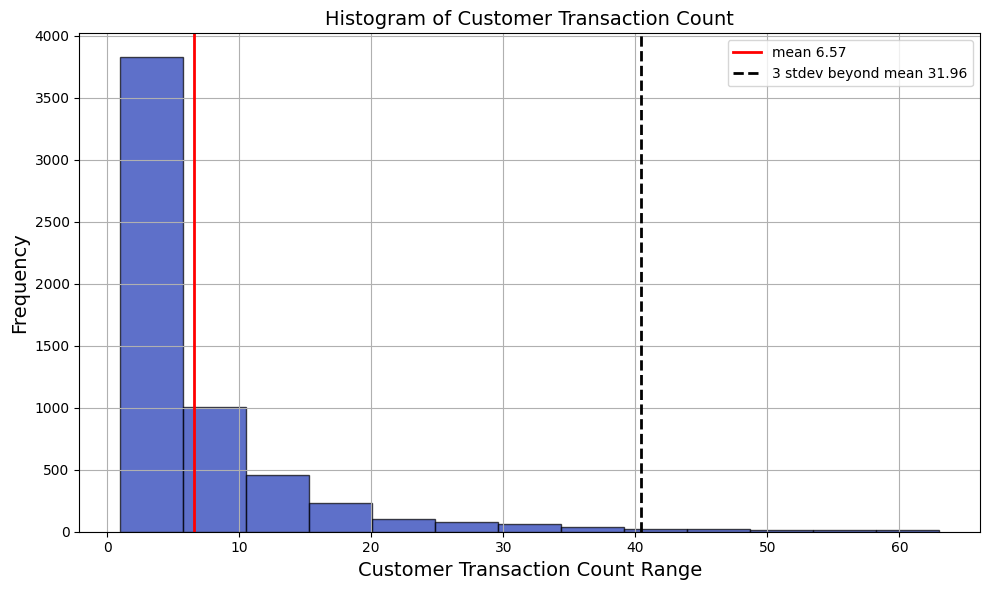

In [41]:
#cust trx counts
customer_sales = outlier_capped_cust_out_removed_trx_data.groupby('Customer ID')['Invoice'].count().reset_index()
customer_sales.columns = ['Customer ID', 'Invoice_Count']
stdev_index = customer_sales['Invoice_Count'].std()
mean = customer_sales['Invoice_Count'].mean()

# Plotting the histogram of outlier index
plt.figure(figsize=(10, 6))
plt.hist(customer_sales['Invoice_Count'], bins=13, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
plt.axvline(stdev_index*4+mean, color='black', linestyle = '--',linewidth=2, label=f'3 stdev beyond mean {stdev_index*3+mean:,.2f}')
plt.title("Histogram of Customer Transaction Count", fontsize=14)
plt.xlabel("Customer Transaction Count Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Understanding seasonal trends and growth in the data.  Weekly trend chart of customer sales.  Note the high sales peaks during the holiday season.  These peaks are nearly 3x the typical sales / wk.

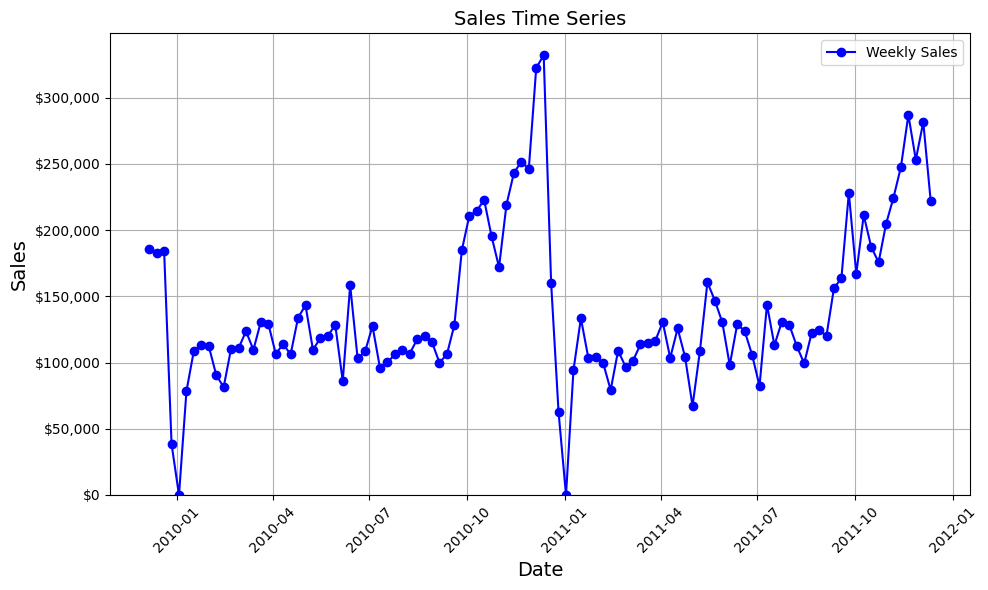

In [9]:
plot_df = outlier_capped_cust_out_removed_trx_data.copy()

# Set 'InvoiceDate' as the index
plot_df.set_index('InvoiceDate', inplace=True)

# Resample by week and sum the 'SKU_sales'
weekly_sales = plot_df['SKU_sales'].resample('W').sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales['InvoiceDate'], weekly_sales['SKU_sales'], label='Weekly Sales', color='blue', marker='o', linestyle='-')
plt.title("Sales Time Series", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Ensure y-axis displays integer values with dollar signs
ax = plt.gca()
ax.set_ylim(bottom=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))

plt.tight_layout()
plt.show()

This is the function the simulator uses to randomly assign test and control customers. 
It creates test and control groups randomly, then determines if the randomly created test meets given specifications.  If the test meets specifications, the test and control customer lists are returned.  If it doesn't meet specs, a new random selection is drawn until a selection that meets specifications is found.
if bias = false and max_lift= false, the first test drawn is returned
if bias = false and max_lift = true, then max_lift is used to specify the maximum test vs control difference that is allowed to exist.  0.1 is a 10% difference in pre period sales between test and control.
A user can specify whether they want a biased test or not.  If a user wants a positively biased test, with minimal pre period significance of 90% and maximum significance of 99%, they would specify bias=true, pos_bias=true, min_bias = 0.1, max bias = 0.01
max_attempts, is the maximum number of random draws to make before giving up.  It is there to prevent infinite loops.


In [17]:

def get_test(all_customers_sales_df: pd.DataFrame, 
             customers_df: pd.DataFrame, 
             pre_start_date: str, 
             pre_end_date: str, 
             bias: bool = True, 
             pos_bias: bool = True, 
             min_bias: float = 0.2, 
             max_bias: float = 0.01,  
             max_lift_selection: bool = False, 
             max_lift: float = 0.1, 
             num_test: int = 5000, 
             num_control: int = 5000, 
             max_attempts: int = 100) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Creates  test and control groups from customer sales data based on given pre-period sales.  Can create tests with a bias (ie test and control
    are significantly different, no bias, or tests with a lift within a range.  When creating biased tests, the software will draw random test and control
    until it finds a test that meets the required conditions.
    
    Args:
        all_customers_sales_df (pd.DataFrame): DataFrame containing all customer sales data.
        customers_df (pd.DataFrame): DataFrame containing customer pool for selection.
        pre_start_date (str): Start date for the pre-period.
        pre_end_date (str): End date for the pre-period.
        bias (bool): Whether to create a biased test group. Defaults to True.
        pos_bias (bool): Whether to create a positive bias. Defaults to True.
        min_bias (float): Minimum p-value for bias. Defaults to 0.2.
        max_bias (float): Maximum p-value for bias. Defaults to 0.01.
        max_lift_selection (bool): Whether to apply a maximum lift selection. Defaults to False
        max_lift (float): Maximum allowed lift. Defaults to 0.1.
        num_test (int): Number of test customers to select. Defaults to 5000.
        num_control (int): Number of control customers to select. Defaults to 5000.
        max_attempts (int): Maximum number of attempts to find a biased test group. Defaults to 100.
        
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: DataFrames of test and control customer ids.
    """
    if bias and max_lift_selection:
        raise ValueError("Cannot create a test with both max_lift and bias")
    
    # Constants for column names
    CUSTOMER_ID_COL = 'Customer ID'
    INVOICE_DATE_COL = 'InvoiceDate'
    SKU_SALES_COL = 'SKU_sales'
    
    def create_random_test_groups(customers_df: pd.DataFrame, num_test: int, num_control: int) -> tuple[pd.DataFrame, pd.DataFrame]:
        test_df = customers_df.sample(n=num_test)
        control_df = customers_df.drop(test_df.index).sample(n=num_control)
        return test_df, control_df

    attempt = 0
    
    while attempt < max_attempts:
        attempt += 1
        
        # Filter the data for the pre-period
        pre_period_df = all_customers_sales_df[(all_customers_sales_df[INVOICE_DATE_COL] >= pre_start_date) & 
                                               (all_customers_sales_df[INVOICE_DATE_COL] <= pre_end_date)].copy()
        
        # Create random test and control groups
        test_df, control_df = create_random_test_groups(customers_df, num_test=num_test, num_control=num_control)
        
        # Filter the sales data for the test and control groups
        test_sales_df = pre_period_df[pre_period_df[CUSTOMER_ID_COL].isin(test_df[CUSTOMER_ID_COL])].copy()
        control_sales_df = pre_period_df[pre_period_df[CUSTOMER_ID_COL].isin(control_df[CUSTOMER_ID_COL])].copy()
        
        # Aggregate sales by customer
        test_sales_agg = test_sales_df.groupby(CUSTOMER_ID_COL, as_index=False)[SKU_SALES_COL].sum()
        control_sales_agg = control_sales_df.groupby(CUSTOMER_ID_COL, as_index=False)[SKU_SALES_COL].sum()

        # Merge the sales and customer dataframes
        test_sales_agg = pd.merge(test_df, test_sales_agg, on=CUSTOMER_ID_COL, how='left')
        control_sales_agg = pd.merge(control_df, control_sales_agg, on=CUSTOMER_ID_COL, how='left')

        # Fill missing sales with 0
        test_sales_agg[SKU_SALES_COL] = test_sales_agg[SKU_SALES_COL].fillna(0)
        control_sales_agg[SKU_SALES_COL] = control_sales_agg[SKU_SALES_COL].fillna(0)

        # Perform t-test to check for bias
        t_stat, p_value = stats.ttest_ind(test_sales_agg[SKU_SALES_COL], control_sales_agg[SKU_SALES_COL])
        
        # Calculate mean sales for test and control groups
        test_mean_sales = test_sales_agg[SKU_SALES_COL].mean()
        control_mean_sales = control_sales_agg[SKU_SALES_COL].mean()
        lift = abs((test_mean_sales - control_mean_sales) / control_mean_sales)
        
        # Check bias conditions
        if bias and ((pos_bias and test_mean_sales > control_mean_sales) or not pos_bias) and min_bias < p_value < max_bias:
            return test_df, control_df
        # Check max lift condition
        elif max_lift_selection and lift < max_lift:
            return test_df, control_df
        # Check non-biased condition
        elif not bias and not max_lift_selection:
            return test_df, control_df
        
    raise ValueError(f"Unable to find a biased test group within {max_attempts} attempts.")

Given a dataframe of customer IDs along with the entire sales dataframe with all customers and dates, will return the sales per customer for the given period between start date and end date
Returns as a sales dataframe of customer ids, and sales / customer.  0 fills any customer in the list who did not make a transaction.

In [18]:
def cust_list_to_sales_per_cust(sales_df: pd.DataFrame, 
                                custs_df: pd.DataFrame, 
                                start_date: str, 
                                end_date: str) -> pd.DataFrame:
    """
    Computes total sales per customer within a specified date range.
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing sales data.
        custs_df (pd.DataFrame): DataFrame containing customer information.
        start_date (str): Start date for the sales period (inclusive).
        end_date (str): End date for the sales period (inclusive).
        
    Returns:
        pd.DataFrame: DataFrame containing customers and their corresponding total sales within the specified period.
    """
    
    # Constants for column names
    INVOICE_DATE_COL = 'InvoiceDate'
    CUSTOMER_ID_COL = 'Customer ID'
    SKU_SALES_COL = 'SKU_sales'
    
    # Filter sales data within the specified date range
    sales_time_slice = sales_df[(sales_df[INVOICE_DATE_COL] >= start_date) & 
                                (sales_df[INVOICE_DATE_COL] <= end_date)].copy()
    
    # Filter sales data to include only the customers in custs_df
    sales_cust_time_slice = sales_time_slice[sales_time_slice[CUSTOMER_ID_COL].isin(custs_df[CUSTOMER_ID_COL])]
    
    # Aggregate sales by customer
    sales_df_summed = sales_cust_time_slice.groupby(CUSTOMER_ID_COL, as_index=False)[SKU_SALES_COL].sum()
    
    # Merge with the customer list to ensure all customers are included, even those with no sales
    sales_df_nullfill = pd.merge(custs_df, sales_df_summed, on=CUSTOMER_ID_COL, how='left')
    
    # Fill missing sales with 0
    sales_df_nullfill[SKU_SALES_COL] = sales_df_nullfill[SKU_SALES_COL].fillna(0)
    
    return sales_df_nullfill

Given a dataframe of customer IDs along with the entire sales dataframe with all customers and dates, will return the sales dataframe sliced to the given customers and dates between start date and end date
Returns as a sales dataframe of transactions for the customers and dates specified.

In [19]:
#get sales dataframe from a customer list
def cust_list_to_sales_df(sales_df: pd.DataFrame, 
                          custs_df: pd.DataFrame, 
                          start_date: str, 
                          end_date: str) -> pd.DataFrame:
    """
    Filters sales data for a specified list of customers within a given date range.
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing sales data.
        custs_df (pd.DataFrame): DataFrame containing customer information.
        start_date (str): Start date for the sales period (inclusive).
        end_date (str): End date for the sales period (inclusive).
        
    Returns:
        pd.DataFrame: DataFrame containing sales data for the specified customers within the given date range.
    """
    
    # Constants for column names
    INVOICE_DATE_COL = 'InvoiceDate'
    CUSTOMER_ID_COL = 'Customer ID'
    
    # Filter sales data within the specified date range
    sales_time_slice = sales_df[(sales_df[INVOICE_DATE_COL] >= start_date) & 
                                (sales_df[INVOICE_DATE_COL] <= end_date)].copy()
    
    # Filter sales data to include only the customers in custs_df
    sales_cust_time_slice = sales_time_slice[sales_time_slice[CUSTOMER_ID_COL].isin(custs_df[CUSTOMER_ID_COL])]
    
    return sales_cust_time_slice

Measures a test, returning key stats comparing test group vs control group avg sales.  
pre_lift is pre period lift, post lift is post period lift, pre vs post is test post - test pre * (control post/ control pre). 

returns results as a dictionary of values.  

In [20]:
#measurement function
def measurement(sales_df: pd.DataFrame, 
                test_custs_df: pd.DataFrame, 
                control_custs_df: pd.DataFrame, 
                pre_start_date: pd.Timestamp, 
                pre_length: pd.Timedelta, 
                pre_post_buffer: pd.Timedelta, 
                post_length: pd.Timedelta) -> dict:
    """
    Measures the lift in sales between test and control groups before and after a specified period.
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing sales data.
        test_custs_df (pd.DataFrame): DataFrame containing test customers.
        control_custs_df (pd.DataFrame): DataFrame containing control customers.
        pre_start_date (pd.Timestamp): Start date for the pre-period.
        pre_length (pd.Timedelta): Duration of the pre-period.
        pre_post_buffer (pd.Timedelta): Buffer period between pre and post periods.
        post_length (pd.Timedelta): Duration of the post-period.
        
    Returns:
        dict: Dictionary containing calculated lift and average sales values.
    """
    
    # Constants for column names
    SKU_SALES_COL = 'SKU_sales'
    
    # Calculate date ranges
    pre_end_date = pre_start_date + pre_length
    post_start_date = pre_end_date + pre_post_buffer
    post_end_date = post_start_date + post_length

    # Calculate sales for test and control groups during pre and post periods
    test_pre_values = cust_list_to_sales_per_cust(sales_df, test_custs_df, pre_start_date, pre_end_date)
    test_post_values = cust_list_to_sales_per_cust(sales_df, test_custs_df, post_start_date, post_end_date)
    control_pre_values = cust_list_to_sales_per_cust(sales_df, control_custs_df, pre_start_date, pre_end_date)
    control_post_values = cust_list_to_sales_per_cust(sales_df, control_custs_df, post_start_date, post_end_date)
    
    # Calculate average sales for test and control groups
    test_pre_avg = test_pre_values[SKU_SALES_COL].mean()
    test_post_avg = test_post_values[SKU_SALES_COL].mean()
    control_pre_avg = control_pre_values[SKU_SALES_COL].mean()
    control_post_avg = control_post_values[SKU_SALES_COL].mean()

    # Calculate lifts
    pre_lift = (test_pre_avg - control_pre_avg) / control_pre_avg * 100
    post_lift = (test_post_avg - control_post_avg) / control_post_avg * 100
    pre_post_expectation = control_post_avg / control_pre_avg * test_pre_avg
    pre_vs_post_lift = (test_post_avg - pre_post_expectation) / pre_post_expectation * 100

    # Perform t-tests to compare means between test and control groups.  not currently using these functions, but they may be useful in another version of this function
    #t_stat_post, p_value_post = stats.ttest_ind(test_post_values[SKU_SALES_COL], control_post_values[SKU_SALES_COL])
    #t_stat_pre, p_value_pre = stats.ttest_ind(test_pre_values[SKU_SALES_COL], control_pre_values[SKU_SALES_COL])

    # Compile results into a dictionary
    results_dictionary = {
        'pre_lift': pre_lift,
        'post_lift': post_lift,
        'pre_vs_post_lift': pre_vs_post_lift,
        'cntl_pre_avg': control_pre_avg,
        'cntl_post_avg': control_post_avg,
        'test_pre_avg': test_pre_avg,
        'test_post_avg': test_post_avg,
        'pre_start_date': pre_start_date
    }

    # Print and return results
    #print(results_dictionary)
    return results_dictionary

This is the main engine used to run simulations.  At the front, you can set the number of iterations, number of test and control customers to be selected, length of pre and post period, delay between.  
returns a dataframe of descriptive stats returned from the measurement function, 1 row per each iteration.


In [21]:
#set the test parameters
test_cust_count = 1000
control_cust_count = 1000
pre_days = 90
post_days = 90
time_between_pre_post = 0
simulations_count = 1000
verbose=False

#make dataframes of the available customers and dates
sales_df = outlier_capped_trx_data.copy()
customers_df = pd.DataFrame(sales_df['Customer ID'].unique(), columns=['Customer ID'])
dates_df = pd.DataFrame(sales_df['InvoiceDate'].unique(), columns=['InvoiceDate']).sort_values(by='InvoiceDate')

#change the day counts into time format
pre_post_buffer = timedelta(days=time_between_pre_post)
pre_length = timedelta(days=pre_days)
post_length = timedelta(days=post_days)

#figure out what are the viable dates to simulate
min_pre_start = dates_df['InvoiceDate'].min() 
max_pre_start = dates_df['InvoiceDate'].max() - pre_length - post_length - pre_post_buffer
viable_pre_start_df = dates_df[(dates_df['InvoiceDate'] > min_pre_start) & (dates_df['InvoiceDate'] < max_pre_start)]

#list of measurements from the simulation.  limited_01 is where I selected test and control until I got a set that were within 1% of each other.
results_list_baseline = []
results_list_lift_limited_01 = []

#simulation runs
for i in range(0,simulations_count):
    if verbose:
        print(f"iteration: {i}")
    #select a random date from the available dates
    pre_start_date = viable_pre_start_df.sample(1, replace=True).iloc[0, 0]

    #align the pre and post start and end with the random pre start date
    pre_end_date = pre_start_date + pre_length
    post_start_date = pre_start_date + pre_length + pre_post_buffer
    post_end_date = pre_start_date + pre_length + pre_post_buffer + post_length

    #select test and control randomly
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=False, max_lift=0.0, num_test=test_cust_count, num_control=control_cust_count, max_attempts=500)

    #test and control measures append to tracking mechanism
    results_baseline = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_baseline.append(results_baseline)

    #select test and control randomly, but below 1% pre period lift
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=True, max_lift=0.01, num_test=test_cust_count, num_control=control_cust_count, max_attempts=1500)

    #test and control measures  append to tracking mechanism
    results_lift_limited_01 = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_lift_limited_01.append(results_lift_limited_01)

#put all of the result lists into dataframes
results_df_baseline = pd.DataFrame(results_list_baseline)
results_df_lift_limited_01 = pd.DataFrame(results_list_lift_limited_01)



A function to create a histogram of the test results for a given treatment.  Input the results dataframe, a metric string indicating which results element to create a histogram for, and 
    version to be able to label the chart with an indication of the test selection parameters used.
    
    Displays a histogram of the results

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def histogram_lift(results_df, metric_string, version):
    """input the results dataframe, a metric string indicating which results element to create a histogram for, and 
    version to be able to label the chart with an indication of the test selection parameters used.
    
    Displays a histogram of the results"""
    # Cust trx counts
    stdev_index = results_df[metric_string].std()
    print(f"stdev: {stdev_index}")
    mean = results_df[metric_string].mean()

    # Plotting the histogram of outlier index
    plt.figure(figsize=(10, 6))
    plt.hist(results_df[metric_string], bins=30, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)

    plt.axvline(stdev_index + 0, color='magenta', linestyle='--', linewidth=2, label=f'1 st dev above 0%, {stdev_index + 0:,.1f}%')
    plt.axvline(-stdev_index + 0, color='magenta', linestyle='--', linewidth=2, label=f'1 st dev below 0% {-stdev_index + 0:,.1f}%')
    plt.axvline(mean, color='gray', linewidth=2, linestyle='--', label=f'mean {mean:,.2f}%')
    plt.axvline(0, color='Black', linewidth=3, label='0% Lift')
    plt.title(f"Histogram of {version}", fontsize=13)
    plt.xlabel("Lift %", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()

    # Adjust grid to make it less obvious
    plt.grid(True, which='both', linestyle='--', color='black', linewidth=0.5, alpha=0.0)

    # Format the x-axis to show percentage signs
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

    plt.tight_layout()
    plt.show()

Histograms for pre period test vs control sales, testing period test vs control, and diff in diff test vs control sales.  These were run for completely random tests as "baseline" and for tests where pre period differences were limited to 1%"

stdev: 20.5067390628829


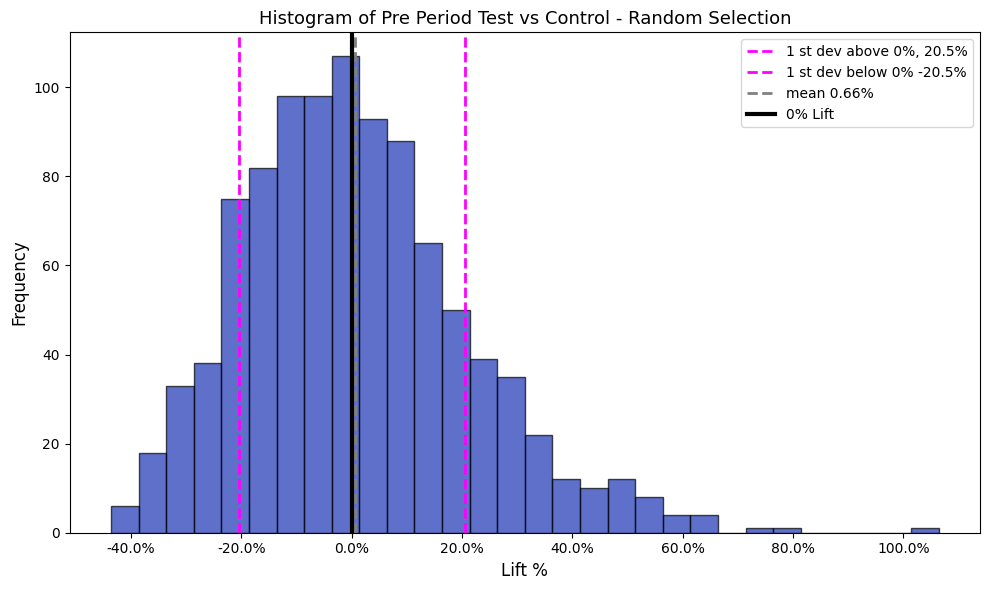

stdev: 19.36092931548775


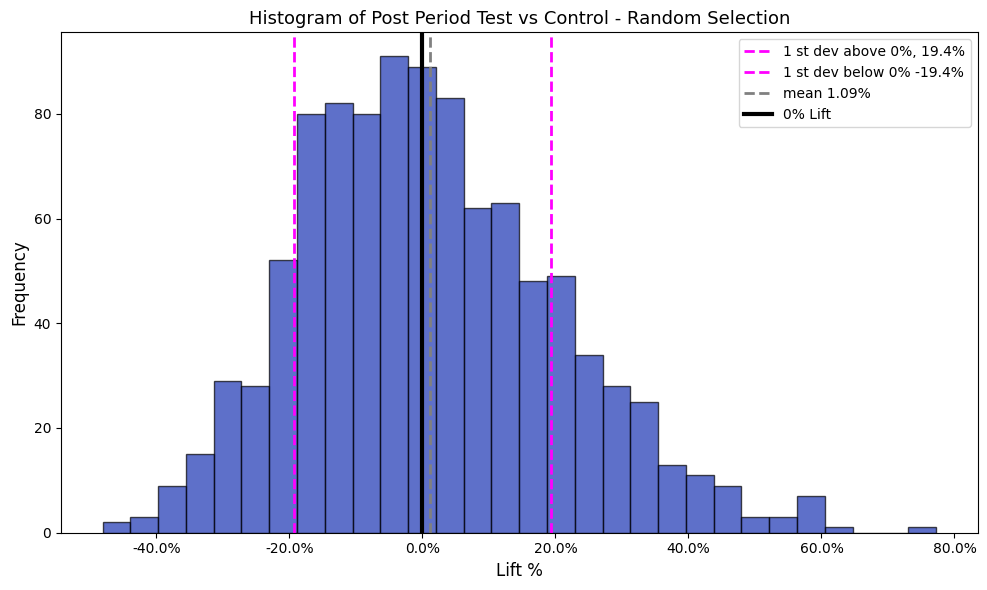

stdev: 13.99724682248745


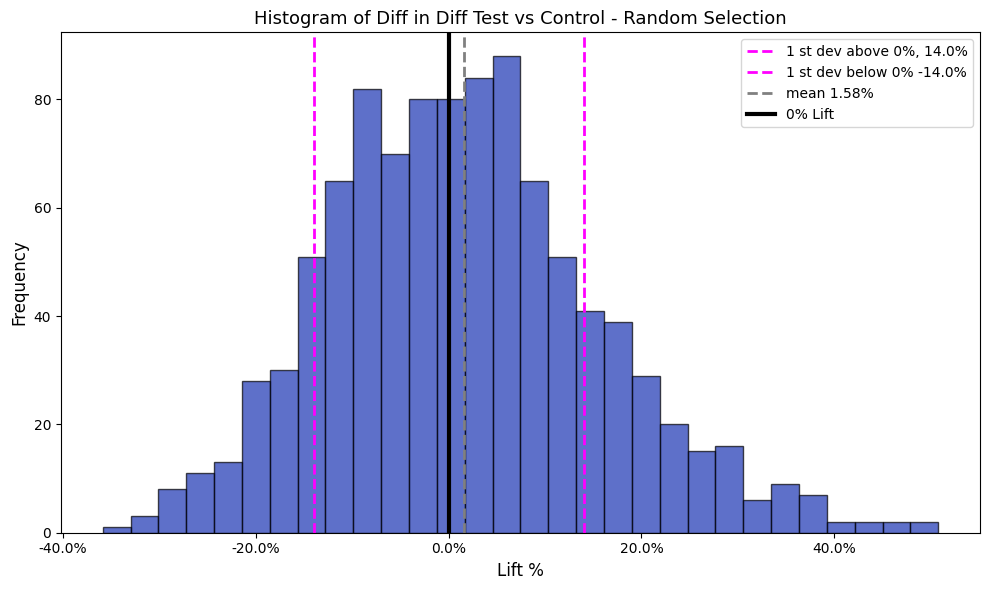

stdev: 0.5822289759428637


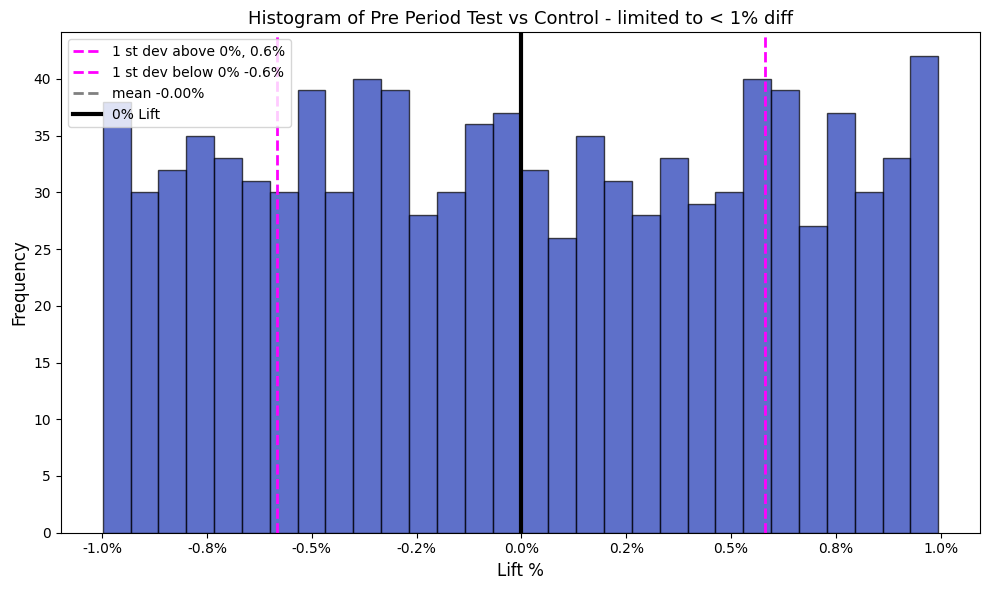

stdev: 11.888766685059506


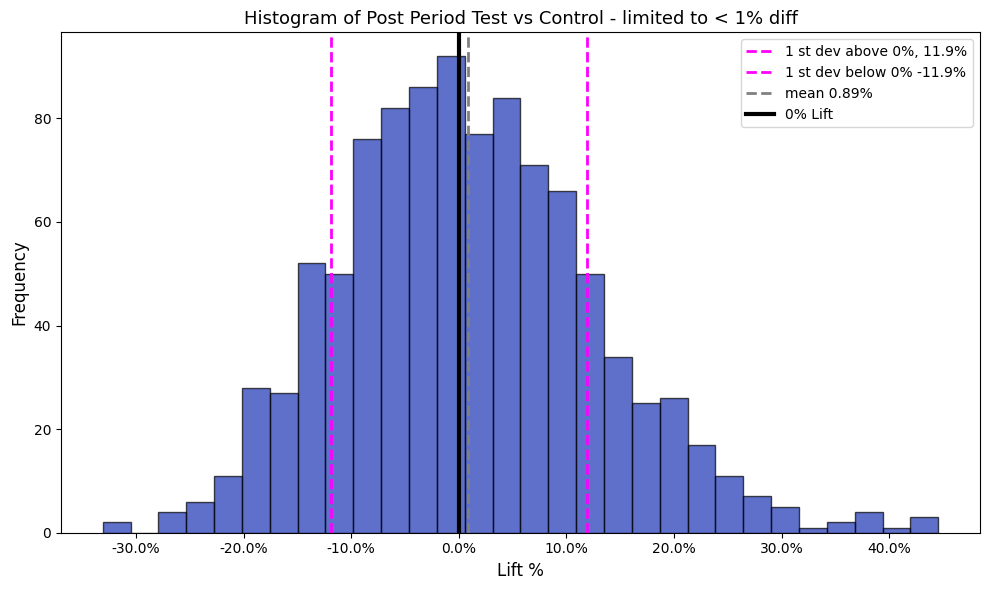

stdev: 11.869420414628406


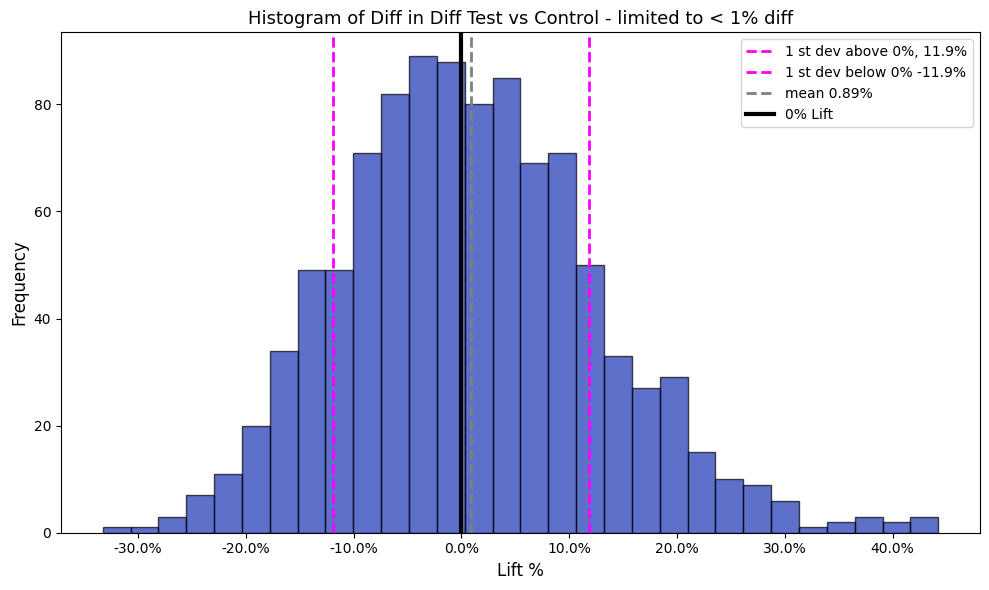

In [23]:
#cust trx counts
histogram_lift(results_df_baseline, 'pre_lift', 'Pre Period Test vs Control - Random Selection')
histogram_lift(results_df_baseline, 'post_lift', 'Post Period Test vs Control - Random Selection')
histogram_lift(results_df_baseline, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - Random Selection')

histogram_lift(results_df_lift_limited_01, 'pre_lift', 'Pre Period Test vs Control - limited to < 1% diff')
histogram_lift(results_df_lift_limited_01, 'post_lift', 'Post Period Test vs Control - limited to < 1% diff')
histogram_lift(results_df_lift_limited_01, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - limited to < 1% diff')


Descriptive stats from the nulltest results, used in the writeup.  correlation of pre and post period lift was used to help explain why diff in diff outperformed post only for completely random tests.  % of results over 40% lift was used as a measure of how many extreme values caome out of each measurement approach.

In [24]:
#statistics from the null tests

#correlation of pre period and post period lift
correl_result = stats.pearsonr(results_df_baseline['pre_lift'], results_df_baseline['post_lift'])[0]
print("The correlation between pre and post lift is:", correl_result)     

# of results >40%
print(f" count of results > 40% lift {results_df_baseline['post_lift'].loc[abs(results_df_baseline['post_lift']) > 40.0].count()}")

# of results >40%
print(f" count of results > 40% lift {results_df_baseline['pre_vs_post_lift'].loc[abs(results_df_baseline['pre_vs_post_lift']) > 40.0].count()}")

# of results >40%
print(f" count of results > 40% lift {results_df_lift_limited_01['post_lift'].loc[abs(results_df_lift_limited_01['post_lift']) > 40.0].count()}")


The correlation between pre and post lift is: 0.7529966968071468
 count of results > 40% lift 38
 count of results > 40% lift 8
 count of results > 40% lift 4


Save the results dataframes to file.  Currently commented out so I don't accidentally over-write my results

In [64]:
#filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/results_df_baseline.csv') 
#results_df_baseline.to_csv(filepath, index=False)
#filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/results_df_lift_limited_01.csv') 
#results_df_lift_limited_01.to_csv(filepath, index=False)


retrieve the saved dataframes from file

In [25]:
results_df_baseline = read_csv("/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/results_df_baseline.csv")
results_df_lift_limited_01 = read_csv("/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/results_df_lift_limited_01.csv")

print a barchart of the results

In [47]:
def results_barchart(results_df, label_char_width):
    add_newlines_to_all_columns(results_df, label_char_width)
    # Check for NaN values and remove them if necessary
    if results_df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. Dropping rows with NaNs.")
        results_df = results_df.dropna()

    # Ensure 'Test_Params' and 'stdev' columns are of correct type
    results_df['Test_Params'] = results_df['Test_Params'].astype(str)
    results_df['stdev'] = results_df['stdev'].astype(float)

    # Debugging print to check the DataFrame before plotting
    print("DataFrame before plotting:")
    print(results_df)

    plt.figure(figsize=(9, 6))
    plt.bar(results_df['Test_Params'], results_df['stdev'], color=(0.1, 0.2, 0.45, 0.45), width=0.5)
    plt.title("Measurements Approaches vs Noise \n  ", fontsize=14)
    plt.xlabel("\nMeasurement Approach", fontsize=14)
    plt.ylabel("Measurement Noise", fontsize=14)
    plt.xticks(fontsize = 12)
    bars = plt.bar(results_df['Test_Params'], results_df['stdev'], color=(0.1, 0.2, 0.45, 0.45), width=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=11, color =(0.0, 0.0, 0.0, 0.9))
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def add_newlines_to_all_columns(df, max_length=40):
    """
    Add newline characters to all columns in a DataFrame every max_length characters,
    ensuring that the text only breaks after completing a word.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to process.
    max_length (int): The maximum length of characters before adding a newline (default is 40).
    
    Returns:
    pd.DataFrame: The DataFrame with modified columns.
    """
    def add_newlines(text, max_length):
        if not isinstance(text, str):
            return text
        words = text.split()
        lines = []
        current_line = ""

        for word in words:
            if len(current_line) + len(word) + 1 > max_length:
                lines.append(current_line)
                current_line = word
            else:
                if current_line:
                    current_line += " "
                current_line += word

        lines.append(current_line)  # Add the last line

        return '\n'.join(lines)

    for column in df.columns:
        df[column] = df[column].apply(lambda text: add_newlines(text, max_length))
    return df





                                         Test_Params      stdev
0  A) Post Period Test vs Control - Random Selection  19.923751
1  B) Baseline + Post Test vs Control - Random Se...  13.567435
2  C) Post Period Test vs Control - difference un...  12.078681
DataFrame before plotting:
                                         Test_Params      stdev
0  A) Post Period Test vs Control\n- Random Selec...  19.923751
1  B) Baseline + Post Test vs\nControl - Random S...  13.567435
2  C) Post Period Test vs Control\n- difference u...  12.078681


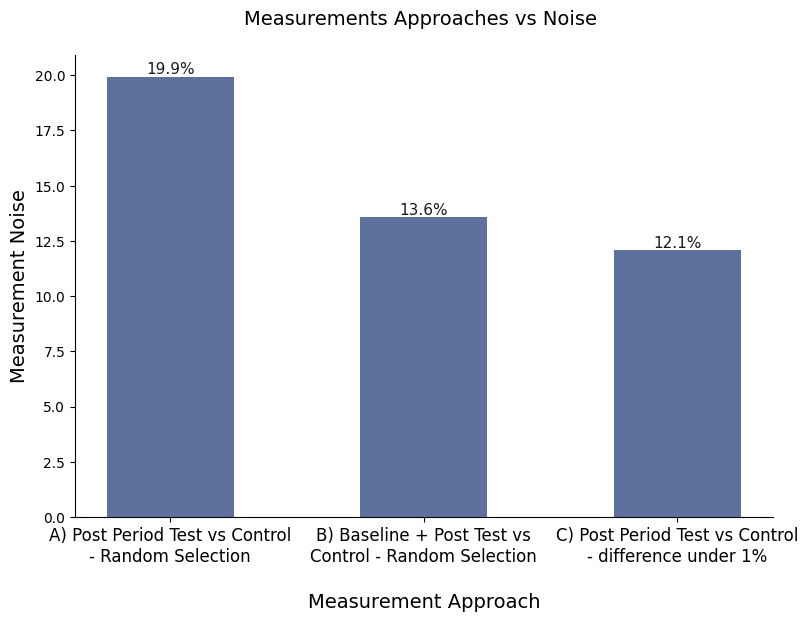

                                         Test_Params      stdev
0     Post Period Test vs Control - Random Selection  19.923751
1  Post Period Test vs Control - difference under 1%  12.078681
DataFrame before plotting:
                                         Test_Params      stdev
0    Post Period Test vs Control -\nRandom Selection  19.923751
1  Post Period Test vs Control -\ndifference unde...  12.078681


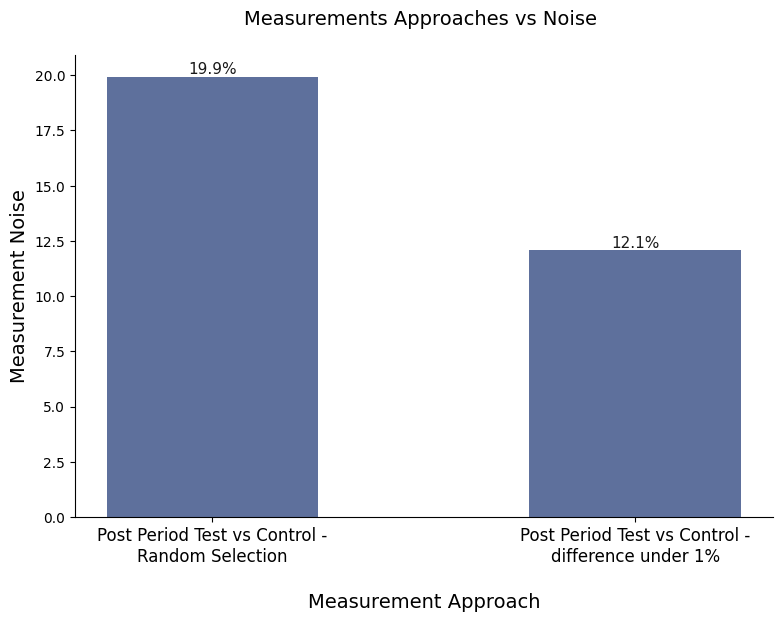

In [57]:
rand_post_only = results_df_baseline['post_lift'].std()
rand_pre_post = results_df_baseline['pre_vs_post_lift'].std()
under_01_post = results_df_lift_limited_01['post_lift'].std()

results_list = []

results_descrip = 'A) Post Period Test vs Control - Random Selection'
results_dict_temp = {'Test_Params' : results_descrip, 'stdev' : rand_post_only}
results_list.append(results_dict_temp)

results_descrip ='B) Baseline + Post Test vs Control - Random Selection'
results_dict_temp = {'Test_Params' : results_descrip, 'stdev' : rand_pre_post}
results_list.append(results_dict_temp)

results_descrip ='C) Post Period Test vs Control - difference under 1%'
results_dict_temp = {'Test_Params' : results_descrip, 'stdev' : under_01_post}
results_list.append(results_dict_temp)

barchart_df = pd.DataFrame(results_list)
print(barchart_df)

results_barchart(barchart_df, 30)


results_list = []

results_descrip = 'Post Period Test vs Control - Random Selection'
results_dict_temp = {'Test_Params' : results_descrip, 'stdev' : rand_post_only}
results_list.append(results_dict_temp)

results_descrip ='Post Period Test vs Control - difference under 1%'
results_dict_temp = {'Test_Params' : results_descrip, 'stdev' : under_01_post}
results_list.append(results_dict_temp)

barchart_df = pd.DataFrame(results_list)
print(barchart_df)

results_barchart(barchart_df, 30)
